# Clasificacion de Letras Escritas a Mano con Redes Neuronales

Comencemos cargando y preparando las herramientas que necesitamos:

In [1]:
print("Instalando librerías necesarias...")
!pip install opencv-python-headless seaborn
print("Librerías instaladas.")

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix

print("\n¡Herramientas cargadas!")

Instalando librerías necesarias...
Librerías instaladas.

¡Herramientas cargadas!


## Paso 1: Cargar y Explorar los Datos de Letras Escritas (EMNIST)

Vamos a cargar un dataset llamado EMNIST (Extended MNIST), que contiene imágenes de letras. Este conjunto de datos nos ayudará a entrenar nuestra red neuronal para que reconozca letras escritas a mano.

In [2]:
print("\nDescargando y cargando el dataset EMNIST/Letters. ¡Esto puede tardar unos minutos la primera vez!")
datos, metadatos = tfds.load('emnist/letters', as_supervised=True, with_info=True)
print("Dataset EMNIST/Letters cargado.")

# Generamos una lista de nombres de las clases (letras)
nombres_clases = [chr(i + ord('a') - 1) for i in range(1, 27)]  # 'a' a 'z'
print("\nNombres de las clases (letras):", nombres_clases)


Descargando y cargando el dataset EMNIST/Letters. ¡Esto puede tardar unos minutos la primera vez!


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/letters/incomplete.BXY2S7_3.1.0/emnist-train.tfrecord*...:   0%|   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/letters/incomplete.BXY2S7_3.1.0/emnist-test.tfrecord*...:   0%|    …

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/letters/3.1.0. Subsequent calls will reuse this data.
Dataset EMNIST/Letters cargado.

Nombres de las clases (letras): ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## Paso 2: Preprocesamiento de los Datos

Las imágenes originales tienen valores de píxeles entre 0 y 255. Para trabajar con redes neuronales, es mejor normalizarlos a una escala de 0 a 1.
Además, ajustaremos las etiquetas de forma que comiencen desde 0.

In [3]:
# Definimos una función simple para aplicar estos dos pasos:
def preprocesar_imagen(imagen, etiqueta):
  # 1. Normalizar píxeles: Convertir a decimal y dividir por 255.
  imagen = tf.cast(imagen, tf.float32) / 255.0
  # 2. Ajustar etiqueta: Restar 1 para empezar desde 0.
  etiqueta = etiqueta - 1
  return imagen, etiqueta # Devuelve la imagen y etiqueta procesadas.

# Aplicamos esta función a todas las imágenes del dataset.
# Separamos en datos para 'entrenamiento' y datos para 'prueba'.
# .map(): Aplica nuestra función de preprocesamiento a cada elemento.
# .cache(): Almacena los resultados en memoria para acelerar el acceso futuro.
datos_entrenamiento = datos['train'].map(preprocesar_imagen).cache()
datos_pruebas = datos['test'].map(preprocesar_imagen).cache()

print("\n¡Datos preprocesados! Listos para ser utilizados por la red neuronal.")


¡Datos preprocesados! Listos para ser utilizados por la red neuronal.


## Paso 3: Visualización de Datos

Antes de avanzar, visualicemos cómo se ven las letras en nuestros datos normalizados. Esto nos dará una mejor idea de lo que estamos trabajando.

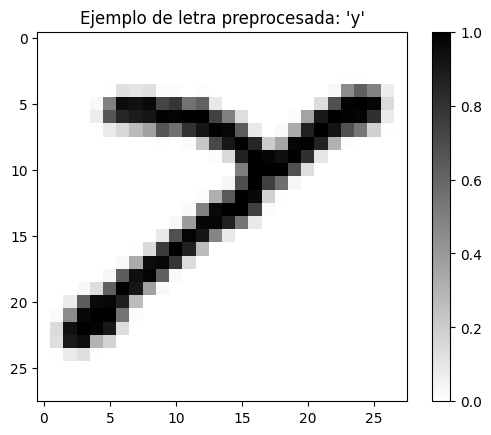

In [4]:
# Extraemos un ejemplo del conjunto de entrenamiento.
for imagen, etiqueta in datos_entrenamiento.take(1):
  # Convertimos los datos a un formato que Matplotlib pueda dibujar.
  imagen_a_mostrar = imagen.numpy()
  etiqueta_numerica = etiqueta.numpy()

# Creamos la visualización.
plt.figure()
# Mostramos la imagen. cmap=plt.cm.binary indica escala de grises.
# Accedemos al contenido de la imagen con [:, :, 0].
plt.imshow(imagen_a_mostrar[:, :, 0], cmap=plt.cm.binary)
# Añadimos un título descriptivo usando nuestra lista de nombres_clases.
plt.title(f"Ejemplo de letra preprocesada: '{nombres_clases[etiqueta_numerica]}'")
plt.colorbar() # Muestra la escala de valores (0 a 1).
plt.grid(False) # Ocultamos la cuadrícula para mayor claridad.
plt.show() # Mostramos el gráfico.

## Paso 4: Construir el Modelo de Red Neuronal

Ahora que tenemos nuestros datos listos, es momento de construir nuestra red neuronal. Utilizaremos un modelo simple llamado Perceptrón Multicapa (MLP).

In [5]:
# Creamos un modelo secuencial (una pila de capas).
modelo = tf.keras.Sequential([
    # 1. Capa Flatten: Convierte la imagen 28x28 en un vector de 784.
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),

    # 2. Capas Ocultas (Dense): Con 64 neuronas cada una y activación 'relu'.
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),

    # 3. Capa de Salida (Dense): 26 neuronas (una por letra), activación 'softmax'.
    tf.keras.layers.Dense(len(nombres_clases), activation='softmax')
])

# Compilamos el modelo, especificando cómo debe aprender:
modelo.compile(
    optimizer='adam', # Algoritmo para ajustar el modelo ('Adam' es eficiente y popular).
    loss='sparse_categorical_crossentropy', # Función para medir el error durante el entrenamiento.
    metrics=['accuracy'] # Métrica para evaluar el rendimiento (porcentaje de aciertos).
)

print("\n¡Modelo de Red Neuronal construido y compilado! Listo para el entrenamiento.")
# Si quieren ver detalles técnicos de las capas (parámetros, etc.), pueden descomentar:
modelo.summary()


¡Modelo de Red Neuronal construido y compilado! Listo para el entrenamiento.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 26)             │         1,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,090 (219.10 KB)

 Trainable params: 56,090 (219.10 KB)

 Non-trainable params: 0 (0.00 B)

## Paso 5: Preparar los Datos para el Entrenamiento

Para entrenar el modelo, necesitamos preparar nuestros datos en lotes eficientes.
También es común mezclar los datos para que el modelo no aprenda de un patrón en específico.

In [6]:
TAMANO_LOTE = 32 # Número de imágenes que el modelo verá en cada paso de entrenamiento.

# Obtenemos el número total de ejemplos de entrenamiento para la mezcla.
num_ejemplos_entrenamiento = metadatos.splits['train'].num_examples

# Preparamos el dataset de entrenamiento:
# .shuffle(): Mezcla los datos aleatoriamente.
# .batch(): Agrupa los datos en lotes del tamaño especificado.
# .repeat(): Permite al proceso de entrenamiento iterar sobre los datos múltiples veces (épocas).
datos_entrenamiento = datos_entrenamiento.shuffle(num_ejemplos_entrenamiento).batch(TAMANO_LOTE).repeat()

# Preparamos el dataset de pruebas: solo necesitamos agruparlo en lotes.
datos_pruebas = datos_pruebas.batch(TAMANO_LOTE)

print(f"\nDatos organizados en lotes de {TAMANO_LOTE} para un entrenamiento eficiente.")


Datos organizados en lotes de 32 para un entrenamiento eficiente.


## Paso 6: ¡Entrenar el Modelo!

Ahora llegó el momento de entrenar la red neuronal. Este proceso permitirá que el modelo aprenda a reconocer letras.

In [7]:
# Definimos cuántas épocas (pasadas completas) de entrenamiento realizaremos.
# Entre 5 y 10 suele ser suficiente para ver un aprendizaje significativo en este problema.
EPOCAS = 15

print(f"\nIniciando el entrenamiento por {EPOCAS} épocas...")
print("Observen cómo la 'accuracy' (precisión) debería mejorar con cada época.")

# Ejecutamos el entrenamiento con model.fit()
historial = modelo.fit(
    datos_entrenamiento, # Los datos preprocesados para entrenar.
    epochs=EPOCAS, # El número de pasadas completas.
    # steps_per_epoch indica cuántos lotes procesar por época para cubrir aprox. todo el dataset.
    steps_per_epoch=math.ceil(num_ejemplos_entrenamiento / TAMANO_LOTE)
    # Opcional: Podemos añadir 'validation_data=datos_pruebas' para ver el rendimiento
    # en los datos de prueba después de cada época, lo cual es muy informativo.
)

print("\n¡Entrenamiento completado! 🎉 El modelo ha finalizado su proceso de aprendizaje.")


Iniciando el entrenamiento por 15 épocas...
Observen cómo la 'accuracy' (precisión) debería mejorar con cada época.
Epoch 1/15
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.6357 - loss: 1.2598
Epoch 2/15
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8358 - loss: 0.5470
Epoch 3/15
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8601 - loss: 0.4462
Epoch 4/15
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8748 - loss: 0.3940
Epoch 5/15
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8841 - loss: 0.3634
Epoch 6/15
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8920 - loss: 0.3345
Epoch 7/15
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8981 - loss: 0.3178
Epoch 8/15
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9010 - loss: 0.3008
Epoch 9/15
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9054 - loss: 0.2880
Epoch 10/15
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9078 - loss: 0.2748
E

## Paso 7: Evaluar el Modelo

Una vez que el modelo ha sido entrenado, es importante evaluarlo con datos que no ha visto antes. Esto nos dirá qué tan bien está funcionando.

In [8]:
print("\nEvaluando el rendimiento del modelo con datos nuevos (conjunto de prueba)...")
# Usamos model.evaluate() para calcular la pérdida y precisión en el conjunto de prueba.
loss_prueba, accuracy_prueba = modelo.evaluate(datos_pruebas)

print(f"\nResultados de la Evaluación:")
print(f"  - Pérdida (Loss) en prueba: {loss_prueba:.4f}")
print(f"  - Precisión (Accuracy) en prueba: {accuracy_prueba:.4f} (Equivalente a {accuracy_prueba*100:.2f}%)")

if accuracy_prueba > 0.80:
    print("\n¡Excelente resultado! Una precisión superior al 80% en datos no vistos indica un buen aprendizaje y generalización. 👍")
elif accuracy_prueba > 0.65:
    print("\n¡Buen resultado! Superar el 65% muestra que el modelo ha captado patrones importantes. ¡Un sólido punto de partida! 😊")
else:
    print("\nEl modelo ha aprendido, pero hay margen de mejora. ¡Parte del proceso es experimentar para optimizar! 💪")


Evaluando el rendimiento del modelo con datos nuevos (conjunto de prueba)...
463/463 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8633 - loss: 0.4681

Resultados de la Evaluación:
  - Pérdida (Loss) en prueba: 0.4651
  - Precisión (Accuracy) en prueba: 0.8635 (Equivalente a 86.35%)

¡Excelente resultado! Una precisión superior al 80% en datos no vistos indica un buen aprendizaje y generalización. 👍


##Paso 7.5: Visualizando la Curva de Aprendizaje 📈

El objeto historial que guardamos durante el entrenamiento (modelo.fit) contiene información valiosa sobre cómo evolucionaron las métricas (como la precisión y la pérdida) en cada época. Graficar esto nos da una visión clara del proceso de aprendizaje.


--- Visualizando el Proceso de Aprendizaje ---


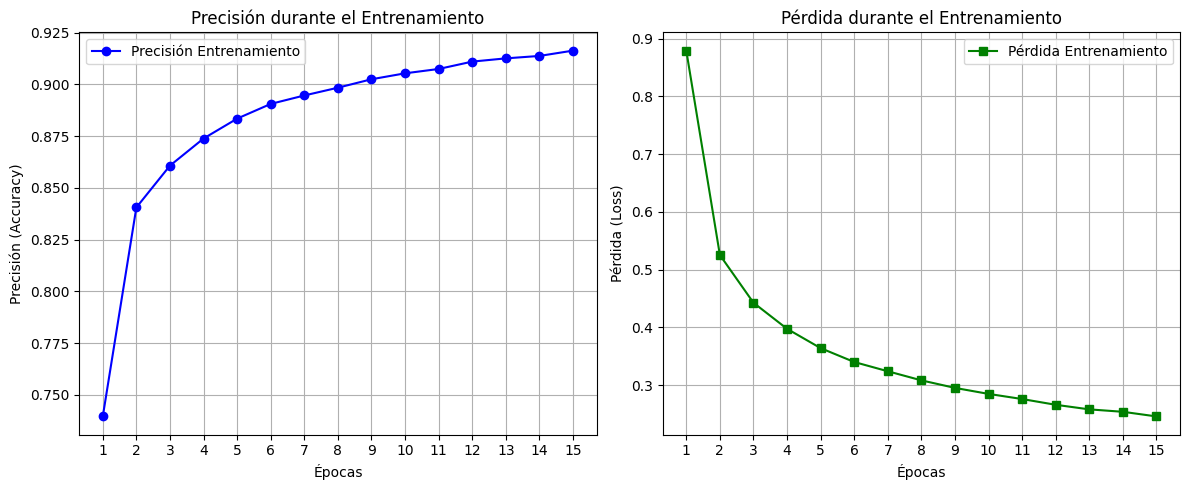


Análisis de las Curvas:
- Idealmente, la Precisión de Entrenamiento debe subir y la Pérdida debe bajar.
- Estas curvas nos ayudan a decidir si necesitamos más/menos épocas, regularización, etc.


In [9]:
print("\n--- Visualizando el Proceso de Aprendizaje ---")

# El objeto 'historial' tiene un diccionario llamado 'history' con las métricas por época.
# Las claves típicas son 'loss', 'accuracy'. Si usamos datos de validación,
# también tendríamos 'val_loss' y 'val_accuracy'.

# Extraemos las métricas del historial.
historial_dict = historial.history
epocas_rango = range(1, EPOCAS + 1) # Creamos una secuencia de números para el eje X (las épocas)

# Graficar la Precisión (Accuracy)
plt.figure(figsize=(12, 5)) # Creamos una figura para los gráficos

plt.subplot(1, 2, 1) # Definimos el primer subgráfico (1 fila, 2 columnas, posición 1)
plt.plot(epocas_rango, historial_dict['accuracy'], 'bo-', label='Precisión Entrenamiento') # 'bo-' = puntos azules conectados
# Si hubiéramos usado datos de validación en fit(), podríamos añadir la curva de validación:
# if 'val_accuracy' in historial_dict:
#    plt.plot(epocas_rango, historial_dict['val_accuracy'], 'ro-', label='Precisión Validación')
plt.title('Precisión durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión (Accuracy)')
plt.xticks(epocas_rango) # Asegura que se muestren todas las épocas en el eje X
plt.legend() # Muestra la leyenda ('Precisión Entrenamiento', etc.)
plt.grid(True) # Añade una grilla para facilitar la lectura

# Graficar la Pérdida (Loss)
plt.subplot(1, 2, 2) # Definimos el segundo subgráfico (1 fila, 2 columnas, posición 2)
plt.plot(epocas_rango, historial_dict['loss'], 'gs-', label='Pérdida Entrenamiento') # 'gs-' = cuadrados verdes conectados
# Si hubiéramos usado datos de validación en fit():
# if 'val_loss' in historial_dict:
#    plt.plot(epocas_rango, historial_dict['val_loss'], 'rs-', label='Pérdida Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Loss)')
plt.xticks(epocas_rango)
plt.legend()
plt.grid(True)

plt.tight_layout() # Ajusta el espaciado entre los subgráficos
plt.show()

print("\nAnálisis de las Curvas:")
print("- Idealmente, la Precisión de Entrenamiento debe subir y la Pérdida debe bajar.")
# Si tuviéramos curvas de validación:
# print("- Si la Precisión de Validación se estanca o baja mientras la de Entrenamiento sigue subiendo,")
# print("  podría ser un signo de 'sobreajuste' (overfitting): el modelo memoriza los datos de entrenamiento")
# print("  pero no generaliza bien a datos nuevos.")
# print("- De forma similar, si la Pérdida de Validación empieza a subir, también indica posible sobreajuste.")
print("- Estas curvas nos ayudan a decidir si necesitamos más/menos épocas, regularización, etc.")

## Paso 8: Visualizar Predicciones

Ahora viene la parte divertida y visual. Vamos a ver qué predice la red para algunas imágenes de prueba y si acertó o no. ¡Vamos a usar unas funciones para graficar esto de forma clara!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


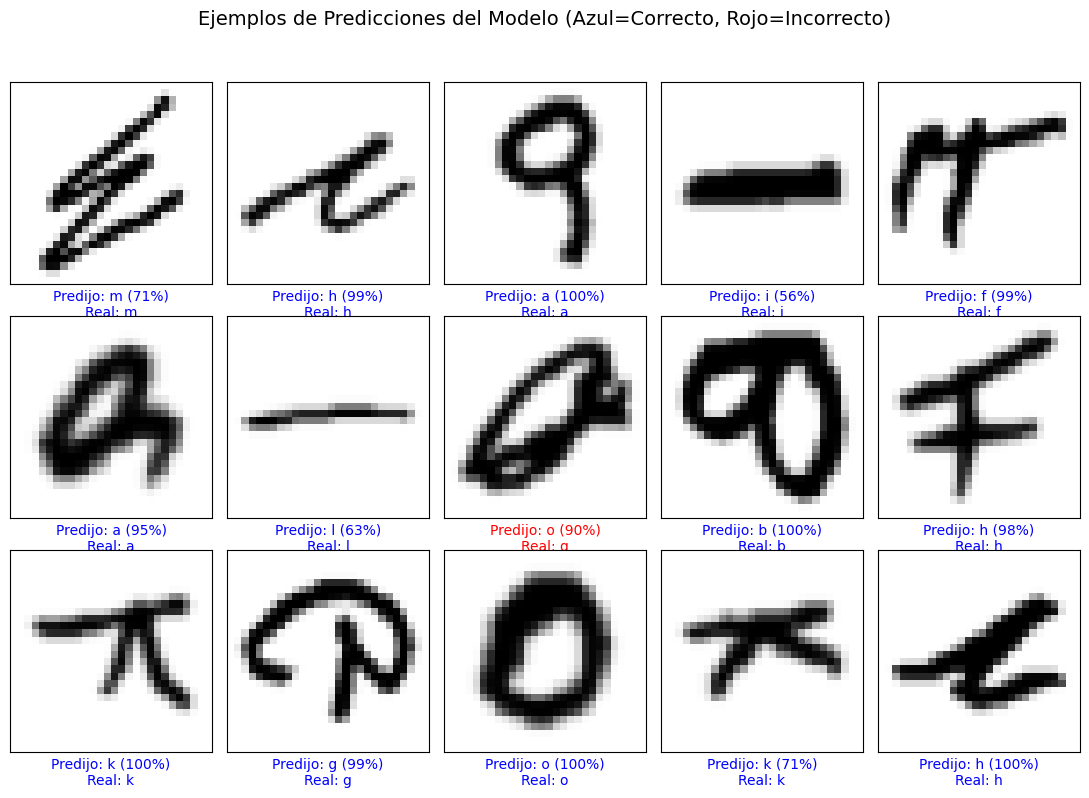

In [10]:
# Tomamos un lote de imágenes y etiquetas del conjunto de prueba.
for imagenes_lote_prueba, etiquetas_lote_prueba in datos_pruebas.take(1):
    imagenes_a_predecir = imagenes_lote_prueba.numpy()
    etiquetas_reales = etiquetas_lote_prueba.numpy()
    # Pedimos al modelo que genere las predicciones (probabilidades para cada letra).
    predicciones_probabilidades = modelo.predict(imagenes_a_predecir)
    break # Solo necesitamos un lote para visualizar.

# Función auxiliar para graficar una imagen con su predicción.
def graficar_prediccion(indice, probabilidades, etiquetas_verdaderas, imagenes):
    probabilidad_predicha = probabilidades[indice]
    etiqueta_verdadera = etiquetas_verdaderas[indice]
    imagen = imagenes[indice]

    plt.grid(False); plt.xticks([]); plt.yticks([]) # Limpiamos ejes y grilla
    plt.imshow(imagen[:, :, 0], cmap=plt.cm.binary) # Mostramos imagen

    # Encontramos la letra con la mayor probabilidad asignada por el modelo.
    indice_predicho = np.argmax(probabilidad_predicha)
    letra_predicha = nombres_clases[indice_predicho]
    letra_real = nombres_clases[etiqueta_verdadera]

    # Asignamos color según si la predicción fue correcta o no.
    color = 'blue' if indice_predicho == etiqueta_verdadera else 'red'

    # Añadimos etiqueta con la predicción, confianza y valor real.
    plt.xlabel(f"Predijo: {letra_predicha} ({100*np.max(probabilidad_predicha):.0f}%)\nReal: {letra_real}", color=color)

# Mostramos un conjunto de predicciones.
num_filas = 3
num_columnas = 5
num_imagenes_a_mostrar = num_filas * num_columnas

plt.figure(figsize=(2 * num_columnas + 1, 2 * num_filas + 2)) # Ajustamos tamaño figura
plt.suptitle("Ejemplos de Predicciones del Modelo (Azul=Correcto, Rojo=Incorrecto)", fontsize=14)
for i in range(num_imagenes_a_mostrar):
    plt.subplot(num_filas, num_columnas, i + 1) # Creamos espacio para cada imagen
    graficar_prediccion(i, predicciones_probabilidades, etiquetas_reales, imagenes_a_predecir)
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajustamos espaciado
plt.show()

## Paso 9: Analizando Errores con la Matriz de Confusión

Para entender mejor cómo se comporta nuestra red, utilizaremos una Matriz de Confusión. Esto nos permitirá visualizar dónde se cometen errores.


Generando la Matriz de Confusión para analizar los errores...
(Requiere procesar todas las predicciones del conjunto de prueba, puede tardar unos instantes)


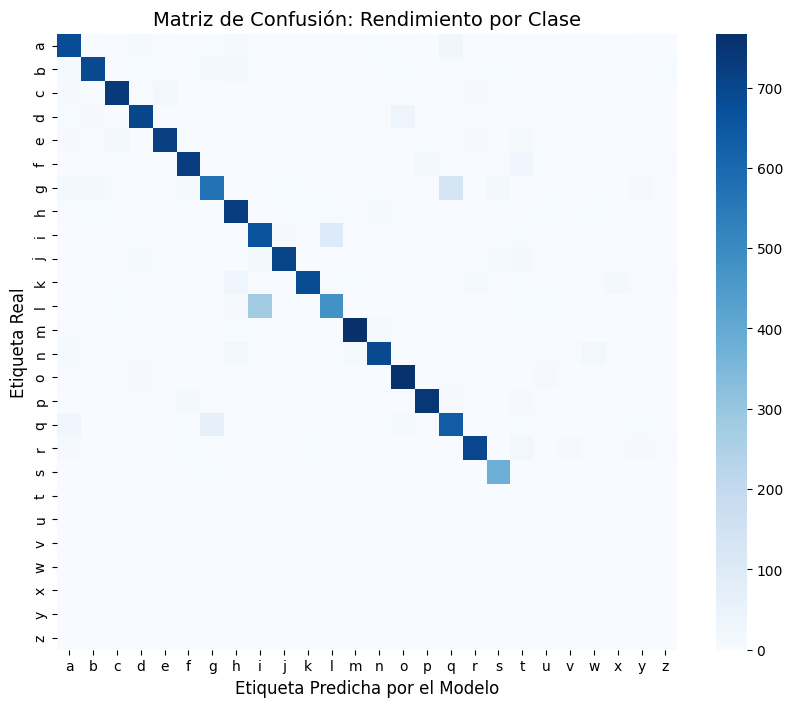


Interpretación de la Matriz de Confusión:
- Cada fila representa las instancias de una letra REAL.
- Cada columna representa las predicciones hechas por el modelo para una letra.
- La DIAGONAL PRINCIPAL (de arriba-izquierda a abajo-derecha) muestra los ACIERTOS.
  (Casos donde la letra real 'X' fue clasificada como 'X'). Idealmente, esta diagonal es intensa (oscura).
- Los valores FUERA de la diagonal representan ERRORES (confusiones).
  (Por ejemplo, un valor en la fila 'i', columna 'l' indica cuántas veces una 'i' real fue clasificada erróneamente como 'l').


In [11]:
print("\nGenerando la Matriz de Confusión para analizar los errores...")
print("(Requiere procesar todas las predicciones del conjunto de prueba, puede tardar unos instantes)")

# Necesitamos obtener las predicciones para TODO el conjunto de prueba.
indices_predichos_todos = []
etiquetas_reales_todas = []

# Iteramos sobre todos los lotes del conjunto de prueba.
for imagenes_lote, etiquetas_lote in datos_pruebas:
    # Obtenemos las predicciones de probabilidad.
    probs_lote = modelo.predict(imagenes_lote, verbose=0)
    # Obtenemos el índice de la clase más probable para cada imagen.
    indices_predichos_lote = np.argmax(probs_lote, axis=1)
    # Acumulamos los resultados.
    indices_predichos_todos.extend(indices_predichos_lote)
    etiquetas_reales_todas.extend(etiquetas_lote.numpy())

# Convertimos a arrays de NumPy para la función de la matriz.
indices_predichos_todos = np.array(indices_predichos_todos)
etiquetas_reales_todas = np.array(etiquetas_reales_todas)

# Calculamos la matriz de confusión.
matriz_conf = confusion_matrix(etiquetas_reales_todas, indices_predichos_todos)

# Visualizamos la matriz usando Seaborn para una mejor presentación.
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_conf, annot=False, cmap='Blues', fmt='d', # annot=False si hay muchas clases
            xticklabels=nombres_clases, yticklabels=nombres_clases)
plt.xlabel('Etiqueta Predicha por el Modelo', fontsize=12)
plt.ylabel('Etiqueta Real', fontsize=12)
plt.title('Matriz de Confusión: Rendimiento por Clase', fontsize=14)
plt.show()

print("\nInterpretación de la Matriz de Confusión:")
print("- Cada fila representa las instancias de una letra REAL.")
print("- Cada columna representa las predicciones hechas por el modelo para una letra.")
print("- La DIAGONAL PRINCIPAL (de arriba-izquierda a abajo-derecha) muestra los ACIERTOS.")
print("  (Casos donde la letra real 'X' fue clasificada como 'X'). Idealmente, esta diagonal es intensa (oscura).")
print("- Los valores FUERA de la diagonal representan ERRORES (confusiones).")
print("  (Por ejemplo, un valor en la fila 'i', columna 'l' indica cuántas veces una 'i' real fue clasificada erróneamente como 'l').")